#### The EfficentNet model

Using effent because it should later run on edge AI device.

In [217]:
########### Basic Parameters for Running: ################################
    
Training_Percentage = 0.2           
Epoch_Anz = 50
nb_classes = 100                     # move to 1. step
#input_shape = (32, 20,1)            # will be calculated
Batch_Size = 32
use_grayscale = True                # grayscale or rgb
model_filename = "eff100-gray.h5"

##########################################################################


### The Model

Effnet as used in distillation

In [218]:
from keras.models import Model
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Rescaling, LayerNormalization

def get_post(x_in):
    x = LeakyReLU()(x_in)
    x = BatchNormalization()(x)
    return x

def get_block(x_in, ch_in, ch_out):
    x = Conv2D(ch_in,
               kernel_size=(1, 1),
               padding='same',
               use_bias=False)(x_in)
    x = get_post(x)

    x = DepthwiseConv2D(kernel_size=(1, 3), padding='same', use_bias=False)(x)
    x = get_post(x)
    x = MaxPool2D(pool_size=(2, 1),
                  strides=(2, 1))(x) # Separable pooling

    x = DepthwiseConv2D(kernel_size=(3, 1),
                        padding='same',
                        use_bias=False)(x)
    x = get_post(x)

    x = Conv2D(ch_out,
               kernel_size=(2, 1),
               strides=(1, 2),
               padding='same',
               use_bias=False)(x)
    x = get_post(x)

    return x


def Effnet(input_shape, nb_classes, include_top=True, weights=None, activation_top=None):
    x_in = Input(shape=input_shape)

    x = get_block(x_in, 32, 64)
    x = get_block(x, 64, 128)
    x = get_block(x, 128, 256)

    if include_top:
        x = Flatten()(x)
        x = Dense(nb_classes, activation=activation_top)(x)

    model = Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model



### Utils Scripts

Various utility scripts now like label-encoding for sin/cos output.

In [219]:
import tensorflow.keras as keras
import math
import numpy as np

def class_encoding(y_train, nb_classes):
    ret = np.zeros((len(y_train), nb_classes))
    for i, y in enumerate(y_train):
        #print(i, y, int((y*10)))
        ret[i, int((y*10))] = 1
    return ret

def class_decoding(y_train, nb_classes=100):
    ret = np.zeros((len(y_train), 1))
    for i, y in enumerate(y_train):
        ret[i] = (np.argmax(y))/10
    return ret

#### Augmentation functions

In [220]:
import cv2
import numpy as np
import random
from scipy.stats import norm
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def invert(imagem):
    if (random.getrandbits(1)):
        return (255)-imagem
    else:
        return imagem
        

Shift_Range = 1 # px
Brightness_Range = [0.4,0.9]
Rotation_Angle = 3
ZoomRange_Out = 0.1
ZoomRange_In = 0.1
ShearRange= 2
Channel_Shift=0.2


def augmentation(x, y, Batch_Size = 32):
    datagen = ImageDataGenerator(width_shift_range=Shift_Range, 
                             height_shift_range=Shift_Range,
                             brightness_range=Brightness_Range,
                             zoom_range=[1-ZoomRange_In, 1+ZoomRange_Out],
                             rotation_range=Rotation_Angle,
                             #channel_shift_range=Channel_Shift,
                             fill_mode='nearest',
                             shear_range=ShearRange
                             ,preprocessing_function=invert
                             ,dtype=float
                             ,rescale=1./255)
    return datagen.flow(x, y, batch_size=Batch_Size)
    


#### Plot functions

In [221]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
def plot_dataset(images, labels, columns=12, rows=5, figsize=(18, 10)):

    fig = plt.figure(figsize=figsize)
    
    for i in range(1, columns*rows +1):
        if (i>len(labels)):
            break
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title(labels[i-1])  # set title
        if(images[i-1].shape[-1]==1):
            plt.imshow((images[i-1]), aspect='auto', cmap='gray')
        else:
            plt.imshow((images[i-1]), aspect='auto')
        plt.tight_layout()
    plt.show()

def plot_dataset_it(data_iter, columns=12, rows=5):

    fig = plt.figure(figsize=(18, 10))
    
    for i in range(1, columns*rows +1):
        img, label = data_iter.next()
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.title(str(class_decoding(label[0].reshape(-1, nb_classes), nb_classes).reshape(-1)))  # set title
        if(img[0].shape[-1]==1):
            plt.imshow(img[0], aspect='auto', cmap='gray')
        else:
            plt.imshow(img[0], aspect='auto')
    plt.show()

def plot_acc_loss(history, modelname="modelname"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(modelname)
    fig.set_figwidth(15)

    if "loss" in history.history:
        ax1.plot(history.history['loss'])
    if "accuracy" in history.history:
        ax2.plot(history.history['accuracy'])
    if "val_loss" in history.history:
        ax1.plot(history.history['val_loss'])
    if "val_accuracy" in history.history:
        ax2.plot(history.history['val_accuracy'])
    if "student_loss" in history.history:
        ax1.plot(history.history['student_loss'])
    if "sparse_categorical_accuracy" in history.history:
        ax2.plot(history.history['sparse_categorical_accuracy'])
    if "val_sparse_categorical_accuracy" in history.history:
        ax2.plot(history.history['val_sparse_categorical_accuracy'])
    if "student_accuracy" in history.history:
        ax2.plot(history.history['student_accuracy'])
    if "val_student_accuracy" in history.history:
        ax2.plot(history.history['val_student_accuracy'])
    if "distillation_loss" in history.history:
        ax1.plot(history.history['distillation_loss'])

    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax1.legend(['train','eval'], loc='upper left')
    axes = plt.gca()
    axes.set_ylim([0.92,1])
    plt.show()


def plot_divergence(divergationset, title1, nb_classes):
    fig = plt.figure(figsize=(40, 10))
    fig.suptitle(title1)
    plt.bar(np.arange (0, nb_classes/10, 0.1), divergationset, width=0.09, align='center')
    plt.ylabel('count')
    plt.xlabel('digit class')
    plt.xticks(np.arange(0, nb_classes/10, 0.1))
    return fig


def confusion_matrix(predicted, y_test, nb_classes):
    ytrue = pd.Series(y_test.reshape(-1), name = 'actual')
    ypred = pd.Series(predicted.reshape(-1), name = 'pred')
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('max_colwidth', None)
    return pd.crosstab(ytrue, ypred)

#### Data loading function

In [222]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

def tmnist_percentals(use_grayscale=True):
    y_train = np.empty((0,1))
    if (use_grayscale):
        x_train = np.empty((0, 32, 20,1))
    else:
        x_train = np.empty((0, 32, 20,3))
    
    blacklist_url = "datasets/font-blacklist.txt"
    blacklist_data = pd.read_csv(blacklist_url, index_col=False)
    #print(blacklist_data.values.reshape(-1))
    
    for i in range(28):

        dataset_url = "datasets/TMNIST_PERCENTAL_"+str((i+1)*1000)+"_Data.csv"
        data = pd.read_csv(dataset_url, index_col=False)
        data = data.drop(data[data['names'].isin(blacklist_data.values.reshape(-1))].index)
        #print(data.head())
        y_tmnist = data[['labels']]
        #print(y_tmnist[y_tmnist.labels>10])
        X = data.drop({'labels','names'},axis=1)

        #print(data)
        X_images = (X.values.reshape(-1,28,28,1))
        # resize but not all for padding
        X_images = tf.image.resize(X_images, (30,22))
        # now pad to make a border (later white)
        # so it looks more like a meter digit
        X_images = tf.image.resize_with_pad(X_images, 32, 20)
        #X_images = tf.image.resize(X_images, (32,20))
        X_images = 255-np.array(X_images).reshape(-1,32,20,1)
        X_images = X_images/255.
            
        if (use_grayscale!=True):
            X_images = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_images))
            

        x_train = np.concatenate((X_images, x_train))
        y_train = np.concatenate((y_tmnist.values, y_train))
    #print(">10", y_train[y_train>10])
    return shuffle(x_train,  y_train, n_samples=len(y_train))



In [223]:
import os
import shutil
from PIL import Image 

def ziffer_data_files(input_dir='images'):
    imgfiles = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if (file.endswith(".jpg") and not file.startswith("10_")):
                #print(root + "/" + file)
                imgfiles.append(root + "/" + file)
    return  imgfiles

def ziffer_data( use_grayscale=True):
    y_file = []
    y_data = []
    x_data = []
    files = ziffer_data_files("images")
    y_data = np.array(y_data).reshape(-1,1)
    y_file = np.array(y_file).reshape(-1,1)
    if (use_grayscale):
        x_data = np.array(x_data).reshape(-1,32,20,1)
    else: 
        x_data = np.array(x_data).reshape(-1,32,20,3)

    for aktfile in files:
        base = os.path.basename(aktfile)
        if (base[1]=="."):
            target = base[0:3]
        else:
            target = base[0:1]
        if target == "N":
            category = 10                # NaN does not work --> convert to 10

        else:
            category = float(target)
        test_image = Image.open(aktfile).resize((20, 32))
        if (use_grayscale):
            test_image = test_image.convert('L')
        test_image = np.array(test_image, dtype="float32")
        test_image = test_image/255.
            
        #print(test_image.shape)
        if (use_grayscale):
            test_image = test_image.reshape(1,32,20,1)
        else:
            test_image = test_image.reshape(1,32,20,3)

        # ignore the category 10
        if ( category<10):
            y_file = np.vstack((y_file, [base]))
            x_data = np.vstack((x_data, test_image))
            y_data = np.vstack((y_data, [category]))
    print("Ziffer data count: ", len(y_data))   
    return x_data, y_data, y_file

def move_to_failure_dir(filename, input_dirs=['images'], failure_dir='failures', ):
    for input_dir in input_dirs:
        for root, dirs, files in os.walk(input_dir):
            for file in files:
                if file.startswith(filename):
                    shutil.move(os.path.join(root, file), os.path.join(failure_dir,file))


#### 

### Load data

Like the distillation network meter digits will be trained with font builded images.

The meter digits are all 0-9 ziffer_raw + my own data 0-9. 
At now no images used between two digits. Many images from 0-9 are +/- 0.2 devergent and not correctly labeled. (See the last result)

Ziffer data count:  2986
dataset x_data-size=275506


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


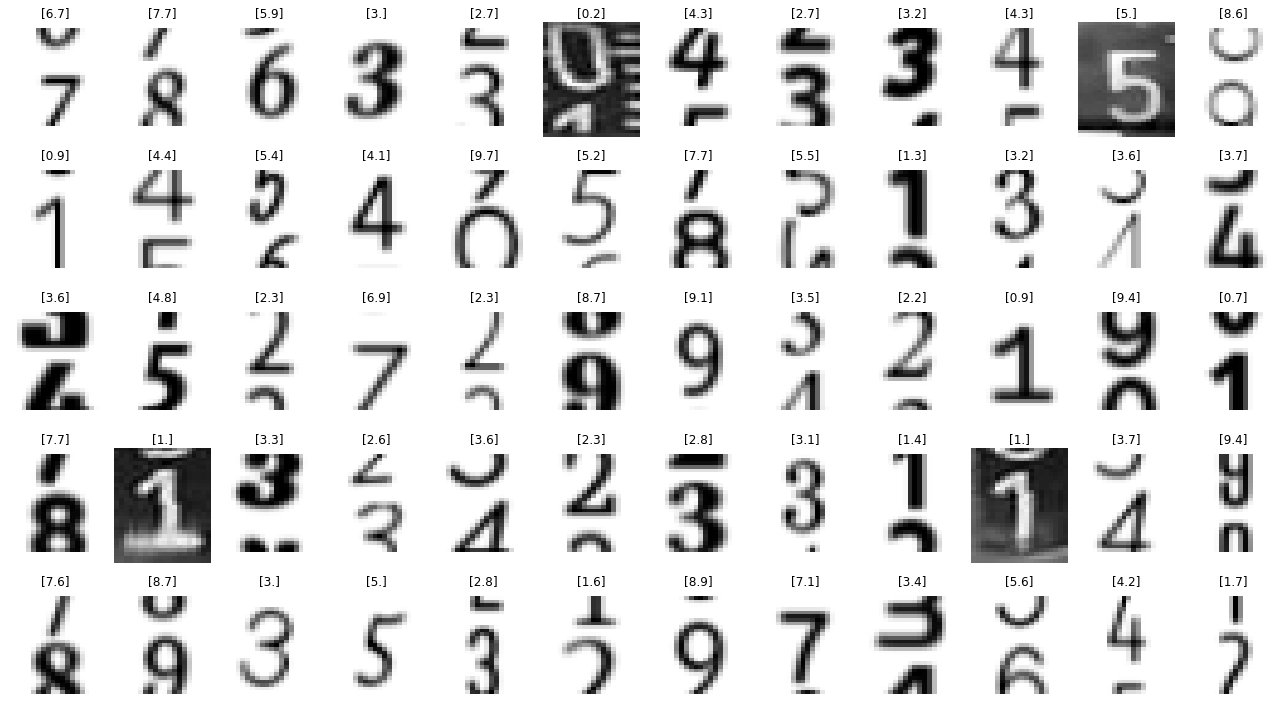

In [224]:
xz_data, yz_data, fz_data = ziffer_data(use_grayscale=use_grayscale)


x_data, y_data = tmnist_percentals(use_grayscale=use_grayscale)
x_data = np.concatenate((x_data, xz_data))
y_data = np.concatenate((y_data, yz_data))
x_data, y_data = shuffle(x_data, y_data)

input_shape=x_data[0].shape
print(f"dataset x_data-size={len(x_data)}")
plot_dataset(x_data, y_data)

y_data = class_encoding(y_data, nb_classes)

### Augmentation
See augementation above for augmentation values.
Standard augmentation of image generator is used plus inverting images.

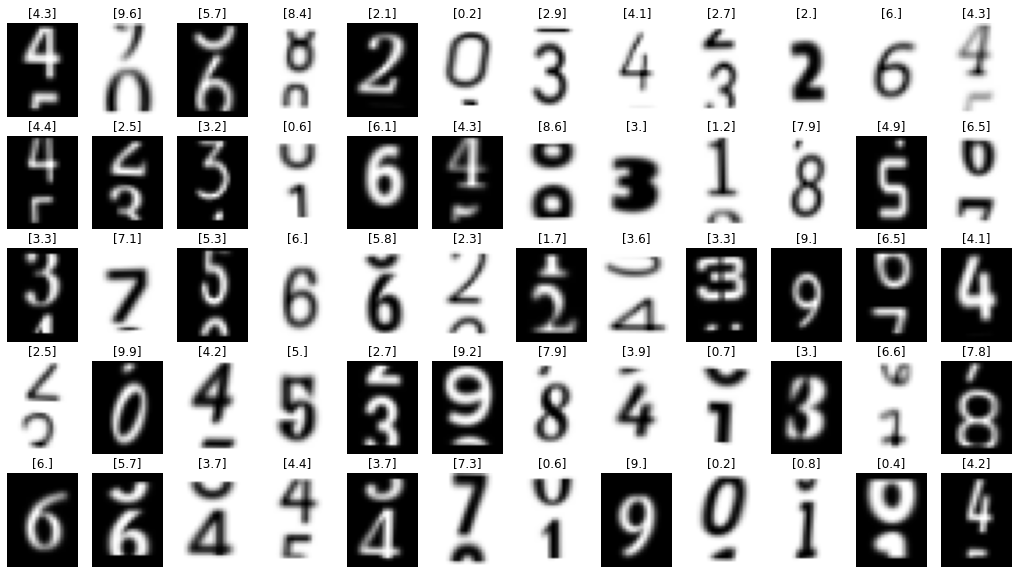

In [225]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split train and validation data 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)

train_iterator = augmentation(x_train, y_train)
validation_iterator = augmentation(x_test, y_test)

plot_dataset_it(train_iterator)       


### The Model

Is an small EfficientNet like model with a dense output of 100 at top. 

In [226]:
import tensorflow as tf

model = Effnet(input_shape, nb_classes, activation_top=None)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics = ["accuracy"])

Epoch 1/50


2022-05-20 20:50:01.570132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6887/6888 [============================>.] - ETA: 0s - loss: 0.2689 - accuracy: 0.9301

2022-05-20 20:51:56.604041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6888/6888 [==============================] - 128s 18ms/step - loss: 0.2689 - accuracy: 0.9301 - val_loss: 0.1091 - val_accuracy: 0.9703
Epoch 2/50
6888/6888 [==============================] - 126s 18ms/step - loss: 0.0887 - accuracy: 0.9737 - val_loss: 0.0835 - val_accuracy: 0.9755
Epoch 3/50
6888/6888 [==============================] - 127s 19ms/step - loss: 0.0621 - accuracy: 0.9813 - val_loss: 0.0628 - val_accuracy: 0.9820
Epoch 4/50
6888/6888 [==============================] - 125s 18ms/step - loss: 0.0492 - accuracy: 0.9852 - val_loss: 0.0549 - val_accuracy: 0.9845
Epoch 5/50
6888/6888 [==============================] - 125s 18ms/step - loss: 0.0414 - accuracy: 0.9873 - val_loss: 0.0512 - val_accuracy: 0.9854
Epoch 6/50
6888/6888 [==============================] - 125s 18ms/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 0.0435 - val_accuracy: 0.9880
Epoch 7/50
6888/6888 [==============================] - 123s 18ms/step - loss: 0.0313 - accuracy: 0.9901 - val_loss: 0.0410 - val

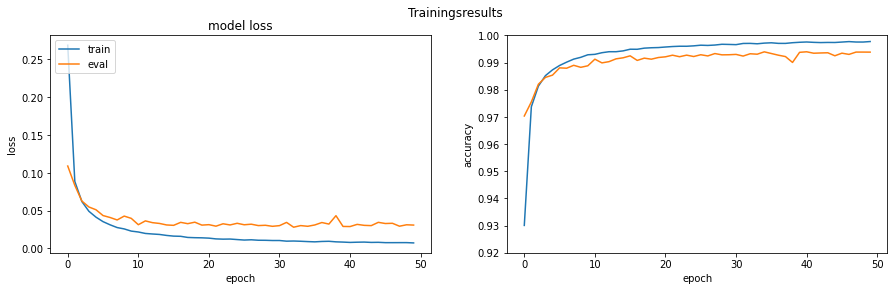

In [227]:
history = model.fit(train_iterator, 
                validation_data=validation_iterator, 
                batch_size=Batch_Size, 
                epochs = Epoch_Anz,
                verbose=1)

plot_acc_loss(history, "Trainingsresults")

model.save(model_filename)

### Verfify the training

Now a few (5000) images from validation set will be used to evaluate the model.

All the first (max 30) false predicted images will be shown.

If all fine the predictions will be shown in a diagram and it should be a sinus and cosinus wave. The glitches are the false predictions.

2022-05-20 22:33:30.791826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Exp: [[7.3]] Pred: [7.4]
Exp: [[7.1]] Pred: [1.1]
Exp: [[6.6]] Pred: [6.7]
Exp: [[7.1]] Pred: [1.1]
Exp: [[1.5]] Pred: [1.6]
Exp: [[2.9]] Pred: [2.8]
Exp: [[1.9]] Pred: [2.]
Exp: [[5.3]] Pred: [3.3]
Exp: [[1.9]] Pred: [2.]
Exp: [[1.9]] Pred: [2.]
Exp: [[1.9]] Pred: [2.]
Exp: [[8.1]] Pred: [2.1]
Exp: [[0.]] Pred: [9.9]
Exp: [[6.7]] Pred: [0.7]
Exp: [[8.8]] Pred: [8.7]
Exp: [[1.3]] Pred: [1.4]
Exp: [[9.8]] Pred: [9.6]
Exp: [[3.2]] Pred: [5.2]
Exp: [[3.1]] Pred: [7.1]
Exp: [[1.8]] Pred: [6.6]
Exp: [[1.9]] Pred: [2.]
Exp: [[4.]] Pred: [3.9]
Exp: [[1.7]] Pred: [1.8]
Exp: [[5.2]] Pred: [8.2]
Exp: [[1.5]] Pred: [2.5]
Exp: [[5.]] Pred: [4.9]
Exp: [[7.7]] Pred: [7.6]
Exp: [[8.2]] Pred: [9.3]
Exp: [[7.8]] Pred: [7.9]
29 false predicted


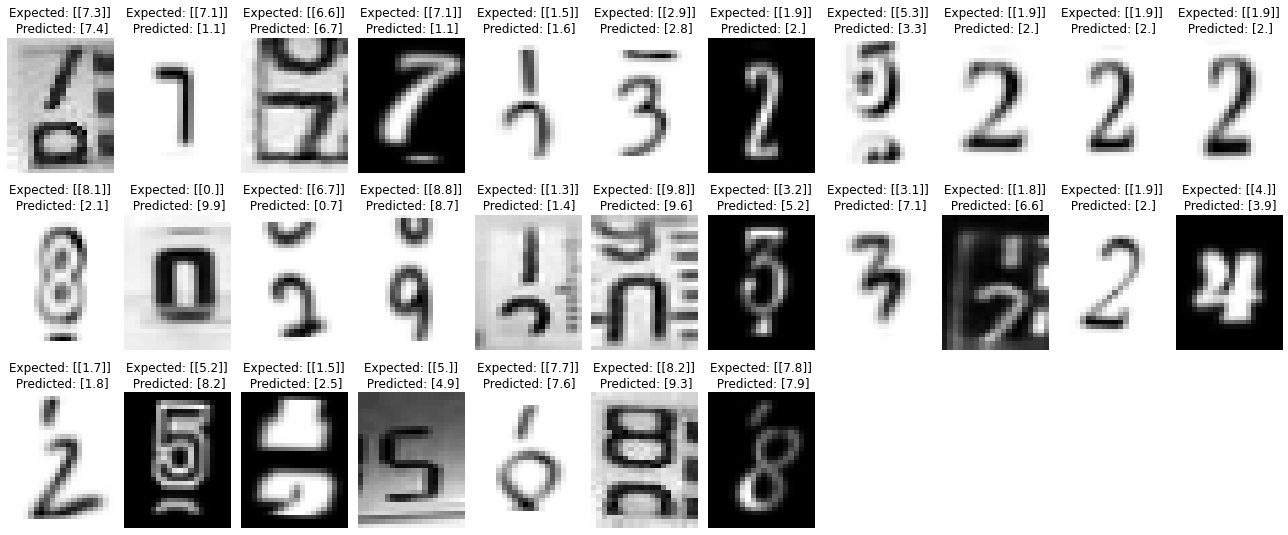

In [228]:
import numpy as np
from operator import itemgetter

res = []
stat_Anz = []
stat_Abweichung = []
false_img = []
false_label = []
test_count = 5000

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for x_test, y_test in validation_iterator:
    if (test_count<0):
        break
    test_count = test_count - Batch_Size
           
    for (x, y) in zip(x_test, y_test):
            
        target = class_decoding([y])
        classes = model.predict(np.expand_dims(x.reshape(input_shape), axis=0))
        
        
        out_target = class_decoding(classes)[0]

                       
        if target != out_target:
            lbl_text = "Expected: " + str(target) + "\n Predicted: " + str(out_target)
            print("Exp: " + str(target) + " Pred: " + str(out_target))
            false_img.append(x)
            false_label.append(lbl_text)
    
for i in range(100):
    if (stat_Anz[i] != 0):
        stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res
print(f"{len(false_label)} false predicted")
plot_dataset(np.array(false_img), false_label, columns=11, rows=4)



### Ziffer images

The model is build for predicting meter digit images (Ziffer). So we test *all* meter digit images of the dataset (not only the validation set)

max_delta can set a value, that ignored convergence +/- of the value and accept it as predicted correctly.

Because of the meter digit dataset (only 0.0, 1.0, ... 9.0) We have no real answer how good the images between two digits are predicted.

Tested images: 2986. 55 false predicted. Accuracy is: 0.9815807099799062


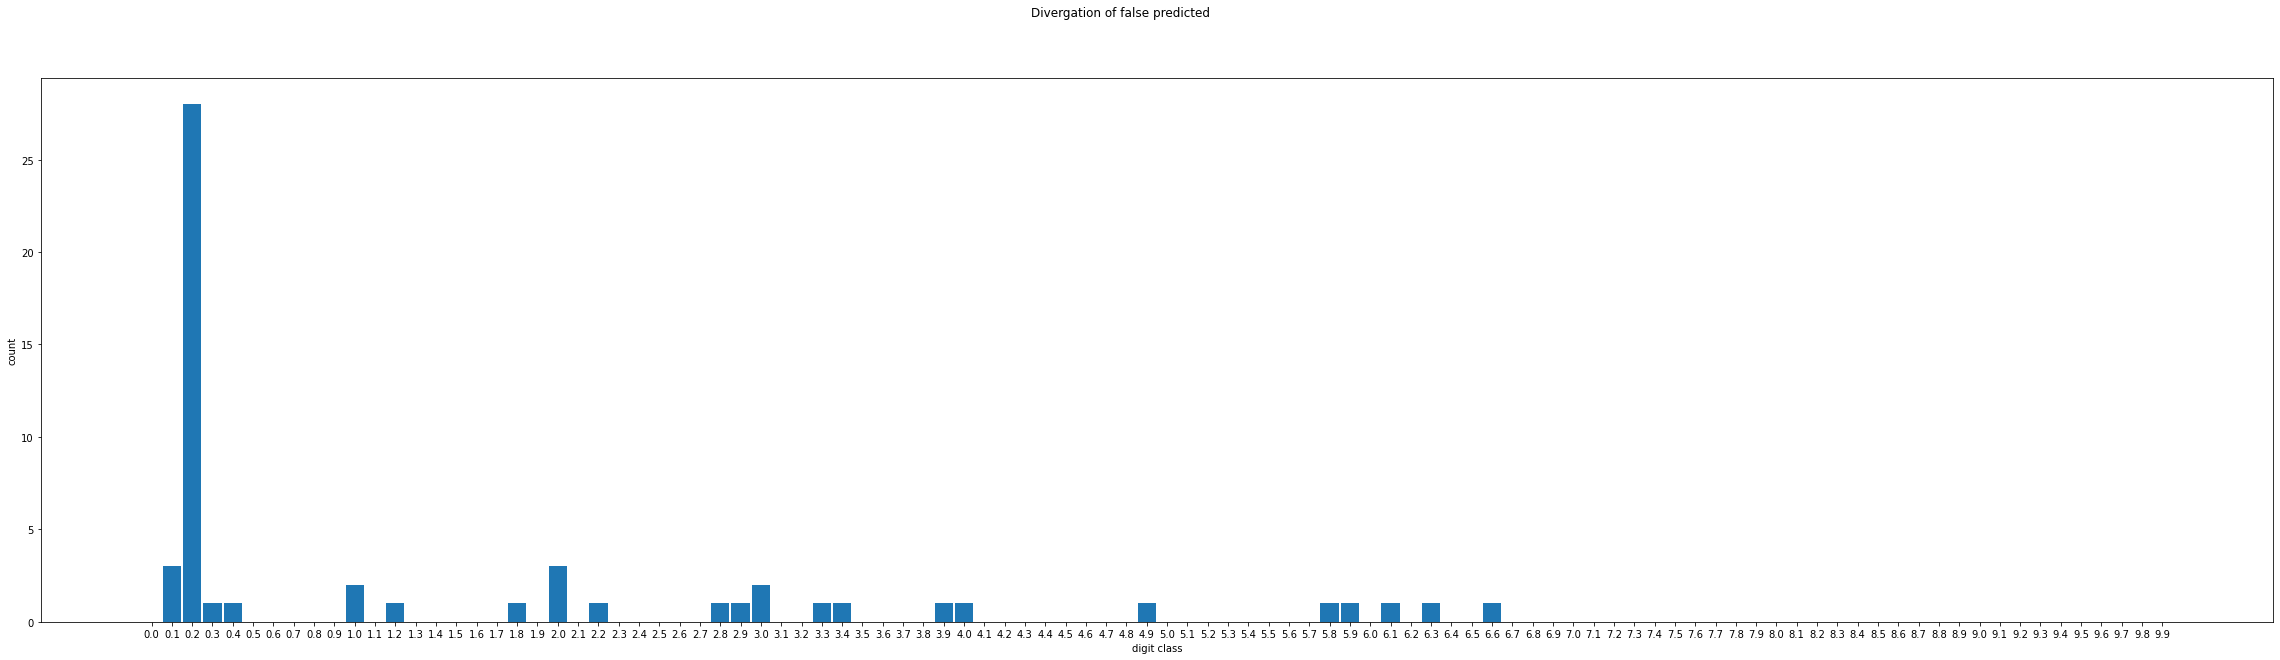

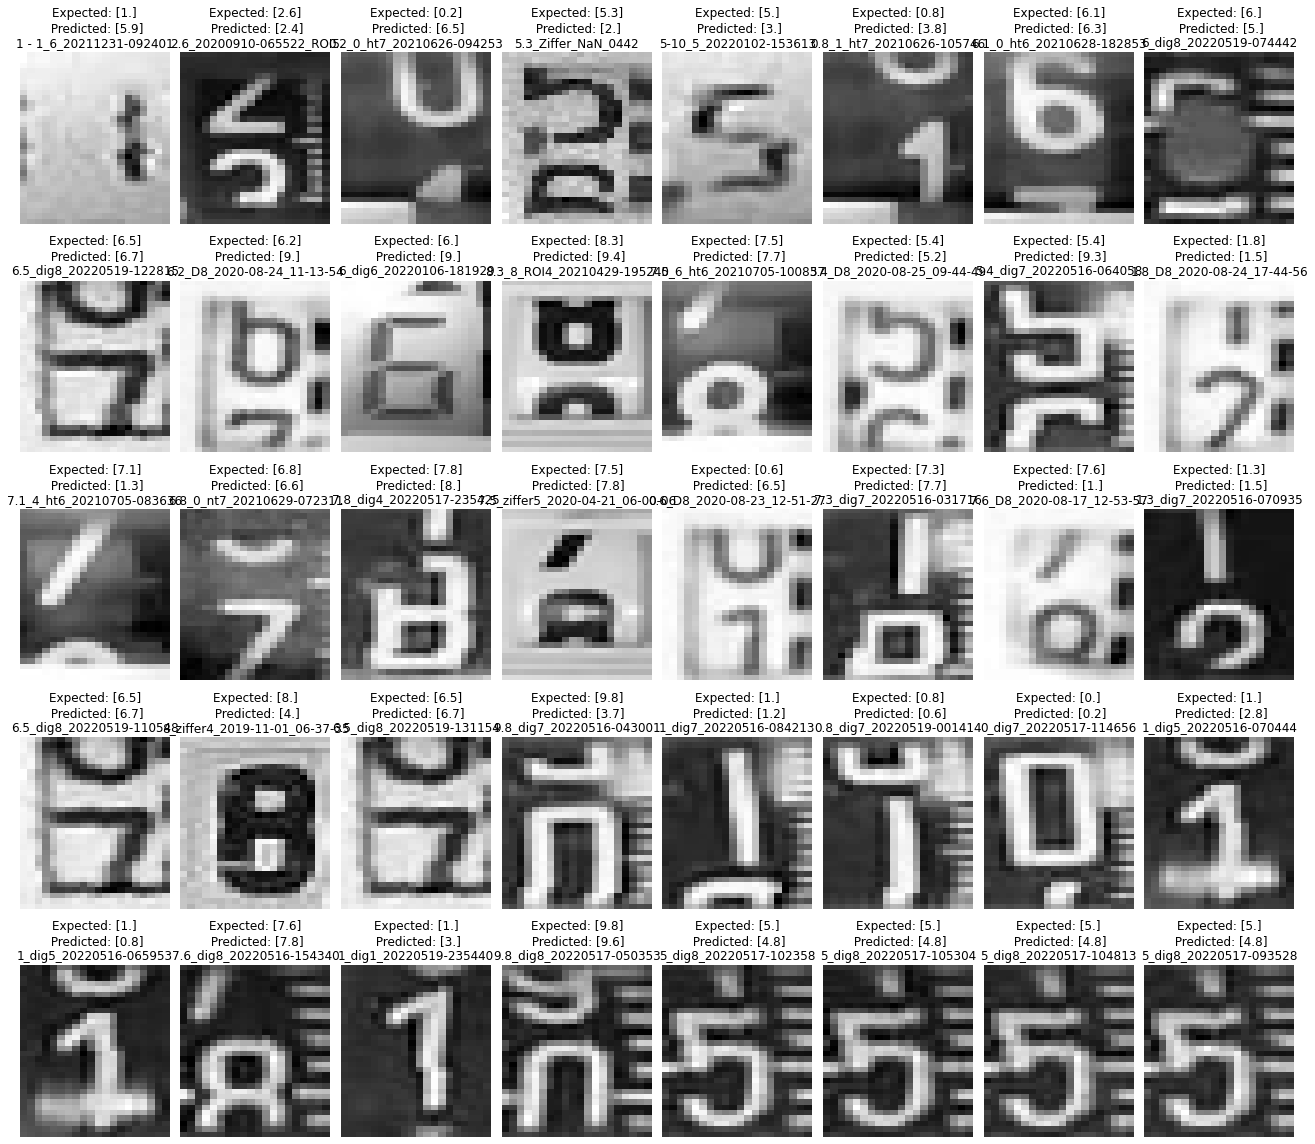

In [229]:
import numpy as np
import math
from operator import itemgetter

res = []
stat_Abweichung = np.zeros(nb_classes)
false_img = []
false_label = []
max_delta = 0.11

def isclose(a, b, delta):
    return min(abs(a-b),abs(a-(10-b)))<=delta


for x, y, filename in zip(xz_data, yz_data, fz_data):

    target = y
    classes = model.predict(np.expand_dims(x.reshape(input_shape), axis=0))
    out_target = class_decoding(classes)[0]
    res.append(out_target)
                   
    if not isclose(target, out_target, max_delta) :
        lbl_text = "Expected: " + str(target) + "\n Predicted: " + str(out_target) + "\n" + filename[0][:-4]
        #print("Exp: " + str(target) + " Pred: " + str(out_target))
        false_img.append(x)
        false_label.append(lbl_text)
        stat_Abweichung[int(abs(target-out_target)*10)] = stat_Abweichung[int(abs(target-out_target)*10)]+1
        # move image to failure_dir 
        move_to_failure_dir(filename[0])

res = np.asarray(res)
res_step_1 = res
print(f"Tested images: {len(yz_data)}. {len(false_label)} false predicted. Accuracy is: {1-len(false_label)/len(yz_data)}")
plot_divergence(stat_Abweichung, "Divergation of false predicted", nb_classes)
#print(confusion_matrix(res, yz_data, nb_classes))
plot_dataset(np.array(false_img), false_label, columns=8, rows=5, figsize=(18,16))